In [1]:
# imports
from datetime import datetime, timedelta
from time import strptime
from textblob import Word
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 25)

# HELPFUL FUNCTIONS

In [2]:
def null_summary(df):
    '''
    A function to tell me feature name, type, percentage of nulls, and how many total for features with nulls.
    '''
    size_df = len(df_lend)
    for column in df_lend:
        null_count = df_lend[column].isna().sum()
        perc_null = round(null_count/size_df*100,2)
        if perc_null == 0:
            continue
        else:
            print(column)
            print('{}, {}% null values, total: {}.'.format(df_lend[column].dtype,perc_null,null_count))
            print('')

In [3]:
def weak_corr(df,dependent,corr=.05):
    '''
    A function to return a list of features in a dataset that correlate weakly to a dependent.
    '''
    depCorr = df.corr()[dependent].sort_values(ascending=False)[1:]

    dropcol = []
    for i,col in enumerate(depCorr.index):
        if np.absolute(depCorr.iloc[i]) < corr:
            print('{} correlation with {} is {}.'.format(col,dependent,depCorr.iloc[i]))
            print('{} should be dropped.'.format(col))
            print('')
            dropcol.append(col)

    return dropcol

In [4]:
def strong_corr(df,dependent,corr=.95):
    '''
    A function to return a list of features in a dataset that correlate strongly to each other. These are then referenced
    against the correlation with the dependent to decide which features to drop.
    '''
    
    corrMatrix = df.drop(columns=dependent).corr()
    depCorr = df.corr()[dependent].sort_values(ascending=False)[1:]
    
    dropcol = []
    for column in corrMatrix.columns:
        for i,col in enumerate(corrMatrix[column].index):
            if col == column:
                continue
            if np.absolute(corrMatrix[column].iloc[i]) > corr:
                print('{} correlation with {} is {}.'.format(column,col,corrMatrix[column].iloc[i]))
                print('')
                if np.absolute(depCorr[column]) > np.absolute(depCorr[col]):
                    print('{} is more ({}) strongly correlated to the dependent than {} ({})'.format(column,depCorr[column],col,depCorr[col]))
                    print('')
                    dropcol.append(col)
                else:
                    print('{} is more ({}) strongly correlated to the dependent than {} ({})'.format(col,depCorr[col],column,depCorr[column]))
                    print('')
                    dropcol.append(column)
    
    return set(dropcol)

In [5]:
def dummy_var(dataframe, dependent = -1, benchmark = .05):
    '''
    A function to get dummy variables of attributes that correlate at least >.05
    
    Parameters:
    dataframe(pandas dataframe) required - the dataframe you wish to turn categorical data to dummy variables
    dependent(int or string) optional - the column number or name that is the dependent
    benchmark(int) optional - the correlation to the dependent that you want, below the number and none of the values
                              in the dummy variable will convert.
    
    Returns:
    A dataframe with dummy variables that have a slight correlation
    '''
    new_df = dataframe.copy()
    for col in new_df:
        # object types are the ones to dummy
        if new_df[col].dtypes == 'O':
            # append the prefix so we don't run into issues later on
            dummy = pd.get_dummies(new_df[col],prefix=col)
            # drop dummied column
            new_df.drop(col, axis = 1, inplace = True)
            dummy[dependent] = new_df[dependent]
            dummy_corr = dummy.corr()
            d = dummy_corr[dependent].sort_values(ascending = False).to_frame()
            # check for a value to have correlation greater than the passed in benchmark
            if d[dependent][1] > benchmark:
                print(str(col) + ' was converted to dummy variables.')
                dummy.drop(dependent, axis = 1, inplace = True)
                # append onto dataframe
                new_df = pd.concat([new_df, dummy], axis = 1)
            # have to check negative correlations
            elif d[dependent][-1] < -benchmark:
                print(str(col) + ' was converted to dummy variables.')
                dummy.drop(dependent, axis = 1, inplace = True)
                # append onto dataframe
                new_df = pd.concat([new_df, dummy], axis = 1)
            else:
                print(str(col) + ' did not have a correlation strong enough.')
    return new_df

In [6]:
def months_since_dec19(date):
    '''
    A function to calculate the months since Dec 19 for a date in MMM-YY format
    '''
    months_to_dec = 12 - strptime(date[0:3],'%b').tm_mon
    month_to_19 = (19 - int(date[4:6]))*12
    total_months = months_to_dec + month_to_19
    return total_months

## INTRODUCTION

Lending Club dataset, the dataset contains individuals that have applied for a loan. Our aim is to predict default from the dataset. Loan status gives us individuals that have either been Charged Off (Defaulted), or Fully Paid. By predicting for charged off loans, we can calculate a risk associated with a loan. This risk can be used to calculate interest rate, or probability of profit on loan for investors.

In [7]:
df_lend = pd.read_csv('lendingclub_2014_ng.csv', dtype = {'percent_bc_gt_75':'f8'})

C:\Users\Thom\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (15,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df_lend.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,36805548,NaN,10400,10400,10400,36 months,321.08,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Dec-14,Charged Off,n,NaN,credit_card,Credit card refinancing,937xx,CA,14.92,0,Sep-89,710,714,2,42.0,NaN,17,0,6133,31.60%,36,w,0.0,0.0,6611.69000,6611.69,5217.75,872.67,0.0,521.27,93.8286,Aug-16,321.08,NaN,Feb-17,564,560,0,59.0,1,Individual,NaN,NaN,NaN,0,0,162110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19400,NaN,NaN,NaN,7,9536.0,7599.0,41.5,0,0,76.0,290,1,1,1,5.0,42.0,1.0,42.0,4,6,9,7,18,2,14,32,9,17,0.0,0,0,4,83.3,14.3,0,0,179407,15030,13000,11325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,38098114,NaN,15000,15000,15000,60 months,336.64,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,Dec-14,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,235xx,VA,12.03,0,Aug-94,750,754,0,NaN,NaN,6,0,138008,29%,17,w,0.0,0.0,17392.37000,17392.37,15000.00,2392.37,0.0,0.00,0.0000,Jun-16,12017.81,NaN,Nov-19,684,680,0,NaN,1,Individual,NaN,NaN,NaN,0,0,149140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184500,NaN,NaN,NaN,5,29828.0,9525.0,4.7,0,0,103.0,244,1,1,0,47.0,NaN,NaN,NaN,0,1,4,1,2,8,5,9,4,6,0.0,0,0,4,100.0,0.0,0,0,196500,149140,10000,12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,37822187,NaN,9600,9600,9600,36 months,326.53,Admin Specialist,10+ years,RENT,69000.0,Source Verified,Dec-14,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,077xx,NJ,25.81,0,Nov-92,680,684,0,NaN,NaN,12,0,16388,59.40%,

In [9]:
df_lend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235607 entries, 0 to 235606
Columns: 146 entries, id to settlement_term
dtypes: float64(68), int64(46), object(32)
memory usage: 262.4+ MB


In [10]:
df_lend['default'] = np.where(df_lend['loan_status']=='Charged Off',1,0)
df_lend.drop(columns=['loan_status'],inplace=True)

## DATA CLEANING

Firstly, I want to see which columns correlate strongly to our dependent and keep those to predict on, similarly I want to see which independents correlate strongly with each other and drop one of them (Ideally the one that has a weaker correlation to the dependent). 

In [11]:
drop = weak_corr(df_lend,'default',corr=.05)
drop

funded_amnt_inv correlation with default is 0.04103554208444288.
funded_amnt_inv should be dropped.

funded_amnt correlation with default is 0.041025297157318896.
funded_amnt should be dropped.

loan_amnt correlation with default is 0.041025297157318896.
loan_amnt should be dropped.

hardship_last_payment_amount correlation with default is 0.03595145090068902.
hardship_last_payment_amount should be dropped.

num_op_rev_tl correlation with default is 0.03143302464186601.
num_op_rev_tl should be dropped.

mths_since_last_record correlation with default is 0.03109732829097081.
mths_since_last_record should be dropped.

num_actv_bc_tl correlation with default is 0.028637588744881187.
num_actv_bc_tl should be dropped.

settlement_amount correlation with default is 0.025684026114364284.
settlement_amount should be dropped.

num_sats correlation with default is 0.02558514563733251.
num_sats should be dropped.

open_acc correlation with default is 0.025261339820068892.
open_acc should be dropp

['funded_amnt_inv',
 'funded_amnt',
 'loan_amnt',
 'hardship_last_payment_amount',
 'num_op_rev_tl',
 'mths_since_last_record',
 'num_actv_bc_tl',
 'settlement_amount',
 'num_sats',
 'open_acc',
 'installment',
 'total_rec_int',
 'pub_rec_bankruptcies',
 'id',
 'pub_rec',
 'delinq_2yrs',
 'num_accts_ever_120_pd',
 'mths_since_last_major_derog',
 'num_bc_sats',
 'num_il_tl',
 'collections_12_mths_ex_med',
 'num_tl_90g_dpd_24m',
 'num_tl_30dpd',
 'num_rev_accts',
 'acc_now_delinq',
 'settlement_percentage',
 'tax_liens',
 'tot_coll_amt',
 'pct_tl_nvr_dlq',
 'mths_since_recent_bc_dlq',
 'chargeoff_within_12_mths',
 'mths_since_last_delinq',
 'mths_since_recent_revol_delinq',
 'num_tl_120dpd_2m',
 'delinq_amnt',
 'total_acc',
 'settlement_term',
 'num_bc_tl',
 'total_il_high_credit_limit',
 'out_prncp_inv',
 'out_prncp',
 'total_bal_ex_mort',
 'mo_sin_old_il_acct',
 'revol_bal',
 'total_rev_hi_lim',
 'mths_since_recent_inq']

In [12]:
df_lend.drop(columns=drop,inplace=True)

In [13]:
drop = strong_corr(df_lend,'default',corr=.95)
drop

fico_range_low correlation with fico_range_high is 0.9999999653260043.

fico_range_low is more (-0.109917423062169) strongly correlated to the dependent than fico_range_high (-0.10991643656135902)

fico_range_high correlation with fico_range_low is 0.9999999653260043.

fico_range_low is more (-0.109917423062169) strongly correlated to the dependent than fico_range_high (-0.10991643656135902)

total_pymnt correlation with total_pymnt_inv is 0.9999974540854656.

total_pymnt is more (-0.2634132674229597) strongly correlated to the dependent than total_pymnt_inv (-0.2634089013044934)

total_pymnt correlation with total_rec_prncp is 0.9589793633193853.

total_rec_prncp is more (-0.40366903547202027) strongly correlated to the dependent than total_pymnt (-0.2634132674229597)

total_pymnt_inv correlation with total_pymnt is 0.9999974540854656.

total_pymnt is more (-0.2634132674229597) strongly correlated to the dependent than total_pymnt_inv (-0.2634089013044934)

total_pymnt_inv correlation

{'collection_recovery_fee',
 'fico_range_high',
 'num_actv_rev_tl',
 'orig_projected_additional_accrued_interest',
 'tot_cur_bal',
 'total_pymnt',
 'total_pymnt_inv'}

In [14]:
df_lend.drop(columns=drop,inplace=True)

In [15]:
df_lend.head(5)

,member_id,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,earliest_cr_line,fico_range_low,inq_last_6mths,revol_util,initial_list_status,total_rec_prncp,total_rec_late_fee,recoveries,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,hardship_payoff_balance_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,default
0,NaN,36 months,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Dec-14,n,NaN,credit_card,Credit card refinancing,937xx,CA,14.92,Sep-89,710,2,31.60%,w,5217.75,0.0,521.27,Aug-16,321.08,NaN,Feb-17,564,560,1,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,9536.0,7599.0,41.5,290,1,1,1,5.0,9,4,14.3,179407,13000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,1
1,NaN,60 months,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,Dec-14,n,NaN,debt_consolidation,Debt consolidation,235xx,VA,12.03,Aug-94,750,0,29%,w,15000.00,0.0,0.00,Jun-16,12017.81,NaN,Nov-19,684,680,1,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,29828.0,9525.0,4.7,244,1,1,0,47.0,4,4,0.0,196500,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,0
2,NaN,36 months,Admin Specialist,10+ years,RENT,69000.0,Source Verified,Dec-14,n,NaN,debt_consolidation,Debt consolidation,077xx,NJ,25.81,Nov-92,680,0,59.40%,f,9600.00,0.0,0.00,Apr-15,9338.58,NaN,Jul-19,714,710,1,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,3214.0,6494.0,69.2,265,23,3,0,24.0,7,3,60.0,52490,21100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,0
3,NaN,60 months,Senior Sales Professional,10+ years,MORTGAGE,125000.0,Verified,Dec-14,n,NaN,car,Car financing,953xx,CA,8.31,Oct-00,665,0,100.90%,w,12800.00,0.0,0.00,Sep-19,1576.08,NaN,Sep-19,664,660,1,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,32727.0,0.0,103.2,170,21,16,5,21.0,5,0,100.0,368700,4400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,0
4,NaN,60 months,Programming Analysis Supervisor,6 years,RENT,63800.0,Source Verified,Dec-14,n,NaN,credit_card,Credit card refinancing,658xx,MO,18.49,Aug-03,685,0,76.20%,w,21425.00,0.0,0.00,May-16,17813.19,NaN,Apr-18,529,525,1,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4232.0,324.0,97.8,136,7,7,0,7.0,4,2,100.0,57073,15000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,0


Next, i'd like to get a count of nulls for each feature. This will give us an idea of what columns can be kept, and what nulls will be filled with. 

In [16]:
null_summary(df_lend)

member_id
float64, 100.0% null values, total: 235607.

emp_title
object, 5.62% null values, total: 13234.

emp_length
object, 5.1% null values, total: 12017.

desc
object, 93.52% null values, total: 220329.

revol_util
object, 0.05% null values, total: 125.

last_pymnt_d
object, 0.06% null values, total: 143.

next_pymnt_d
object, 99.87% null values, total: 235296.

last_credit_pull_d
object, 0.01% null values, total: 26.

annual_inc_joint
float64, 100.0% null values, total: 235607.

dti_joint
float64, 100.0% null values, total: 235607.

verification_status_joint
float64, 100.0% null values, total: 235607.

open_acc_6m
float64, 100.0% null values, total: 235607.

open_act_il
float64, 100.0% null values, total: 235607.

open_il_12m
float64, 100.0% null values, total: 235607.

open_il_24m
float64, 100.0% null values, total: 235607.

mths_since_rcnt_il
float64, 100.0% null values, total: 235607.

total_bal_il
float64, 100.0% null values, total: 235607.

il_util
float64, 100.0% null values

'member_id', columns provide no information to machine learning algorithms.

In [17]:
df_lend.drop(columns = ['member_id'], inplace = True)

'policy_code' has one unique value, drop this feature.

In [18]:
df_lend.drop(columns = ['policy_code'], inplace = True)

'emp_title', this feature will fill nulls with 'other' since their titles can be anything. This will fill 5% of the column with 'other'. Potentially we can just drop this column if there are too many unique values.

In [19]:
len(df_lend['emp_title'].value_counts())/len(df_lend)

0.31980798533150545

Since 30% of the dataset if a unique value for 'emp_title' I decide to drop the column.

In [20]:
df_lend.drop(columns=['emp_title'],inplace=True)

'emp_length', these lengths are categorized by year including '< 1 year' and '10+ years'. Cannot turn the feature into integers since we cannot infer the information for lengths greater than 10. Thus, I have filled the nulls with 'n/a'.

In [21]:
df_lend['emp_length'].fillna('n/a', inplace = True)

'pymnt_plan', this feature provides no information for machine learning model since each row has the same value.

In [22]:
df_lend.drop(columns=['pymnt_plan'], inplace = True)

'desc', feature has 90% nulls, this is also a column which is customer supplied. I drop it.

In [23]:
df_lend.drop(columns=['desc'], inplace = True)

'title' and 'purpose', these convey the same information. 'title' is customer supplied and will be dropped.

In [24]:
df_lend.drop(columns=['title'], inplace = True)

'revol_util', revolving utilization nulls should be filled with the mean value. Feature needs to be converted to floats and then filled with mean.

In [25]:
df_lend['revol_util'] = [str(i)[:-1] for i in df_lend['revol_util']]
df_lend['revol_util'] = np.where(df_lend['revol_util']=='na','NaN',df_lend['revol_util'])
df_lend['revol_util'] = df_lend['revol_util'].astype('float')
df_lend['revol_util'] = df_lend['revol_util'].fillna(np.mean(df_lend['revol_util']))

'last_pymnt_d', this feature is the most recent day a payment was received, some options for filling nulls here. One option, is to fill nulls with most common value in the dataset. Another, create a new feature that includes values that were nulls.

In [26]:
df_lend['last_pymnt_d'].fillna(df_lend['last_pymnt_d'].mode()[0], inplace=True)

'next_pymnt_d', this feature has 99.8% nulls. Probably corresponds to our dataset having no individuals on a payment plan. I drop this column.

In [27]:
df_lend.drop(columns=['next_pymnt_d'],inplace=True)

'last_credit_pull_d', this feature has very few nulls. Replacing nulls with the most common value will not skew this feature.

In [28]:
df_lend['last_credit_pull_d'].fillna(df_lend['last_credit_pull_d'].mode()[0], inplace=True)

'last_fico_range_low', earlier we dropped one of the numbers for the fico range. Here, I drop the corresponding range number for the most recent credit pull.

In [29]:
df_lend.drop(columns=['last_fico_range_high'], inplace=True)

'application_type', these column can represent if the application was a joint/individual application. Since all applications were individual, we drop the column.

In [30]:
df_lend.drop(columns=['application_type'], inplace=True)

'annual_inc_joint','dti_joint','verification_status_joint', these features have 100% nulls so we drop these.

In [31]:
df_lend.drop(columns=['annual_inc_joint','dti_joint','verification_status_joint'], inplace = True)

'open_acc_6m','open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util', these features also all have 100% nulls, so drop these.

In [32]:
df_lend.drop(columns=['open_acc_6m','open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il',
                      'il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util'], inplace = True)

'inq_fi','total_cu_tl','inq_last_12m', are more features that have 100% nulls

In [33]:
df_lend.drop(columns=['inq_fi','total_cu_tl','inq_last_12m'],inplace=True)

'avg_cur_bal', this feature has few nulls so can be filled with median value.

In [34]:
df_lend['avg_cur_bal'].fillna(df_lend['avg_cur_bal'].median(),inplace=True)

'bc_open_to_buy', this feature has 1% nulls so can be filled with median value.

In [35]:
df_lend['bc_open_to_buy'].fillna(df_lend['bc_open_to_buy'].median(),inplace=True)

'mths_since_recent_bc', feature where nulls represent events that never occured. I fill nulls with a large value to represent this. May come back to it depending on accuracy of machine learning.

In [36]:
df_lend['mths_since_recent_bc'].fillna(-999,inplace=True)

'percent_bc_gt_75', float number representing what percentage of bankcards an individual has close to their credit limit. Fill the nulls with 100.00 since this is the most common value.

In [37]:
df_lend['percent_bc_gt_75'].fillna(100.0,inplace=True)

'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', all of these features have to do with joint application accounts. Since there are none in this dataset, we drop all of the columns.

In [38]:
df_lend.drop(columns=['revol_bal_joint','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_earliest_cr_line',
                      'sec_app_inq_last_6mths','sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util',
                      'sec_app_open_act_il', 'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths',
                      'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog'], inplace = True)

'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', these features have to do with accounts that have a hardship flag. There are none in this dataset so we drop them. This may also be information that is supplied after that account has defaulted, so this would be useless in our pursuit to predict default status.

In [39]:
df_lend.drop(columns=['hardship_flag','hardship_type','hardship_reason','hardship_status','deferral_term','hardship_amount',
                      'hardship_start_date', 'hardship_end_date','payment_plan_start_date','hardship_length','hardship_dpd',
                      'hardship_loan_status','hardship_payoff_balance_amount'], inplace = True)

'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term', features have to do with debt settlement. This is information for individuals that have already defaulted. Since the information is supplied later, we do not want to predict with it.

In [40]:
df_lend.drop(columns=['debt_settlement_flag','debt_settlement_flag_date','settlement_status','settlement_date'], inplace = True)

'bc_util', is the utilization of individuals bankcard. Since we do not have data on their exact bankcard credit line and spending we cannot calculate. I fill with mean value.

In [41]:
df_lend['bc_util'].fillna(df_lend['bc_util'].mean(),inplace=True)

## DATA EXPLORATION

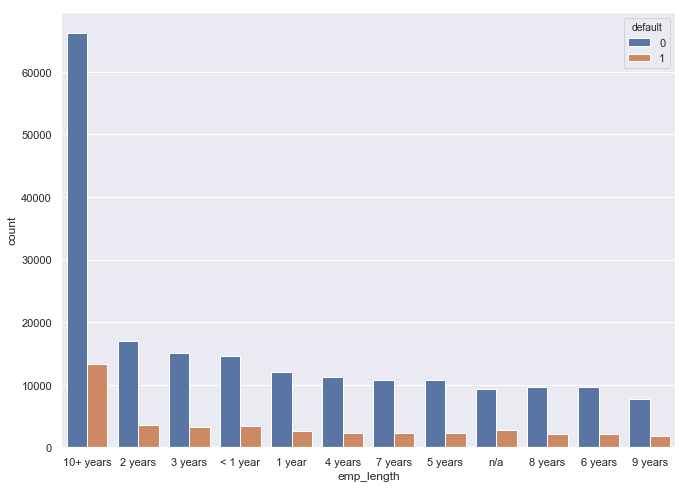

In [42]:
order = df_lend['emp_length'].value_counts().index.tolist()
sns.set(rc={'figure.figsize':(11,8)})
sns.countplot(x='emp_length', hue='default', order = order, data=df_lend)

Text(0, 0.5, 'Percentage of job role Default Risk')

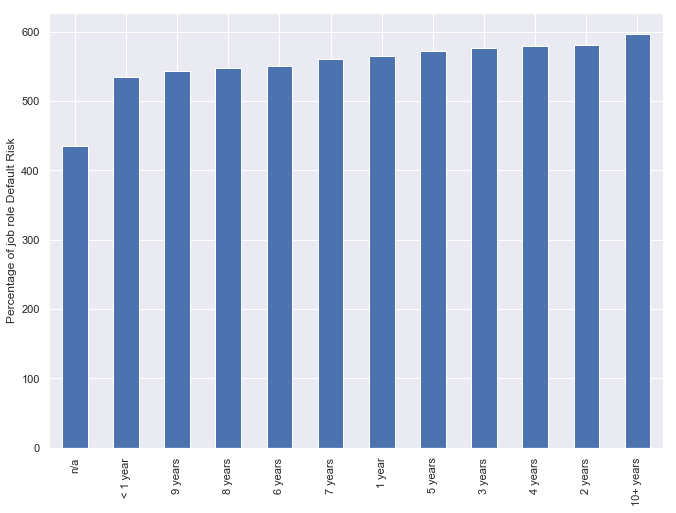

In [43]:
emp_len_counts = df_lend['emp_length'].value_counts()
def_emp_counts = df_lend[df_lend['default']==1]['emp_length'].value_counts()

divide = (emp_len_counts.div(def_emp_counts) * 100).sort_values()
ax = divide.plot.bar()
plt.ylabel('Percentage of job role Default Risk')

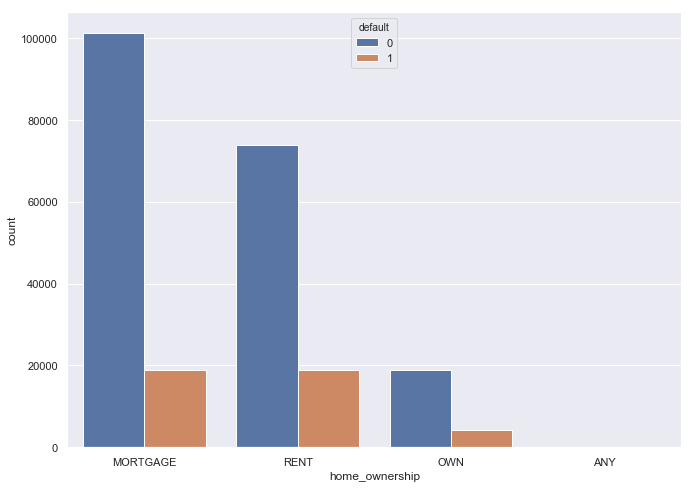

In [44]:
order = df_lend['home_ownership'].value_counts().index.tolist()
sns.set(rc={'figure.figsize':(11,8)})
sns.countplot(x='home_ownership', hue='default', order = order, data=df_lend)

Text(0, 0.5, 'Percentage of job role Low Risk')

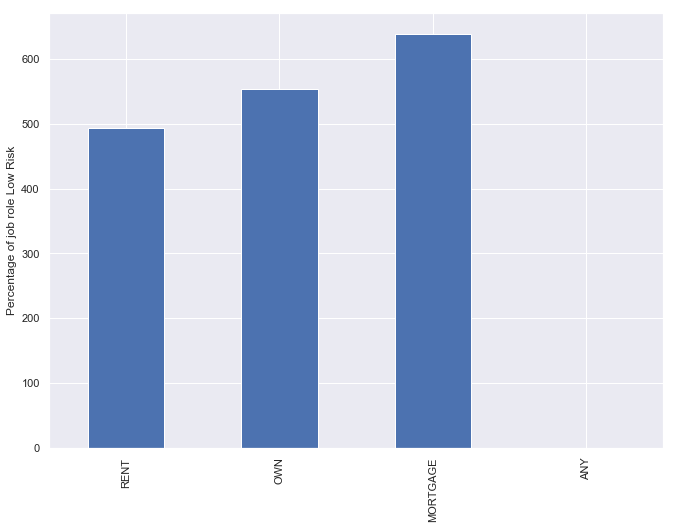

In [45]:
home_count = df_lend['home_ownership'].value_counts()
def_home_count = df_lend[df_lend['default']==1]['home_ownership'].value_counts()

divide = (home_count.div(def_home_count) * 100).sort_values()
ax = divide.plot.bar()
plt.ylabel('Percentage of job role Low Risk')

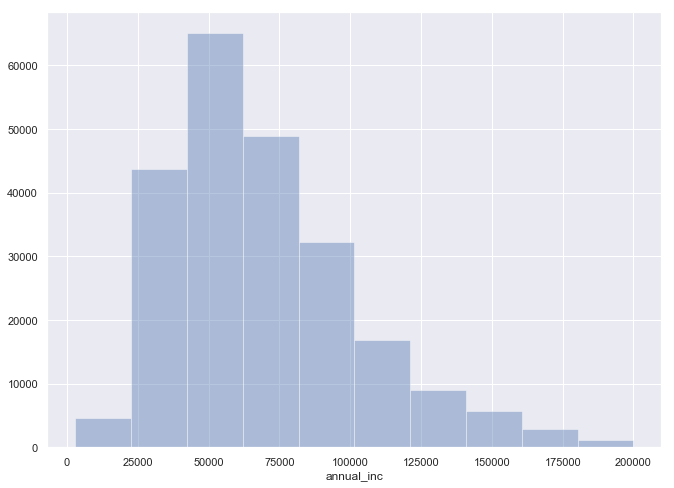

In [46]:
ann_inc_200k = df_lend[df_lend['annual_inc'] < 200000]
sns.set(rc={'figure.figsize':(11,8)})
sns.distplot(ann_inc_200k['annual_inc'],bins=10,kde=False)

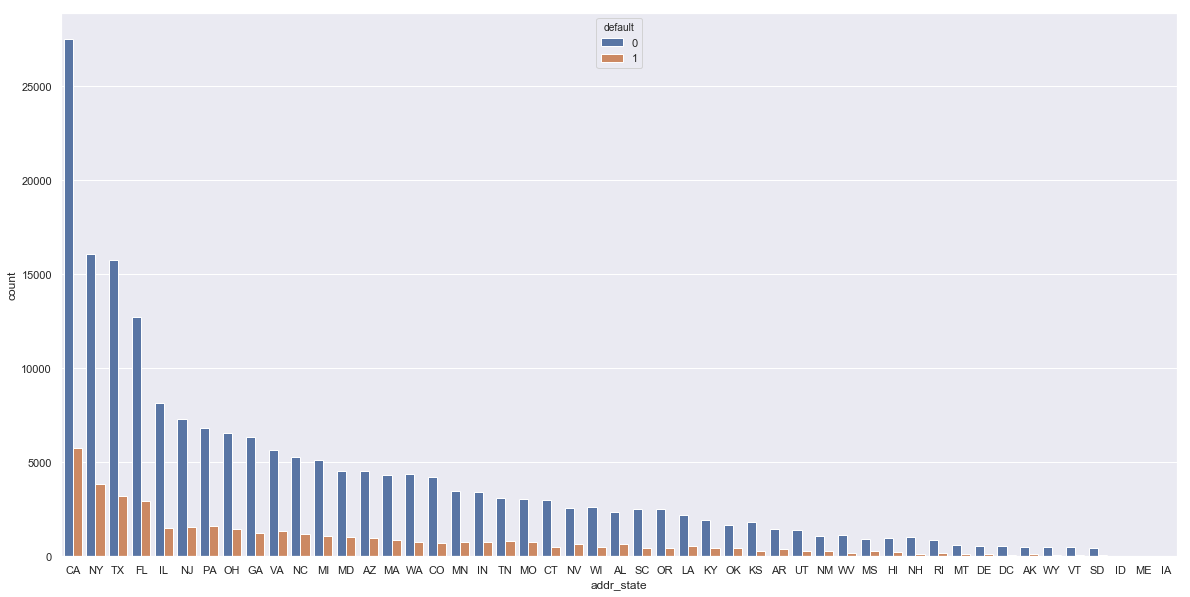

In [47]:
order = df_lend['addr_state'].value_counts().index.tolist()
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x='addr_state', hue='default', order = order, data=df_lend)

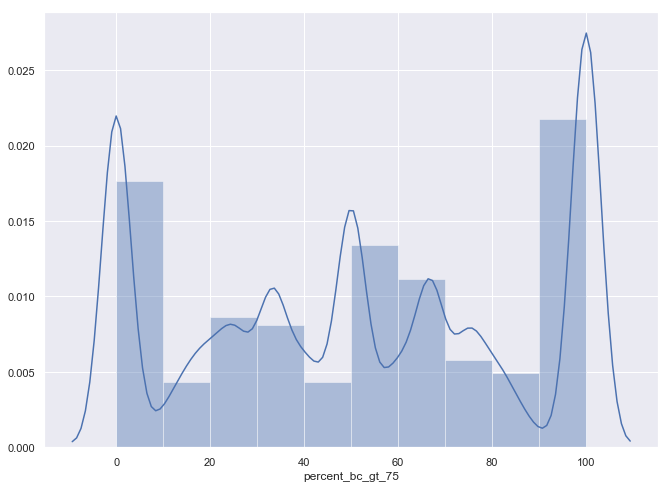

In [48]:
sns.set(rc={'figure.figsize':(11,8)})
sns.distplot(df_lend['percent_bc_gt_75'],bins=10)

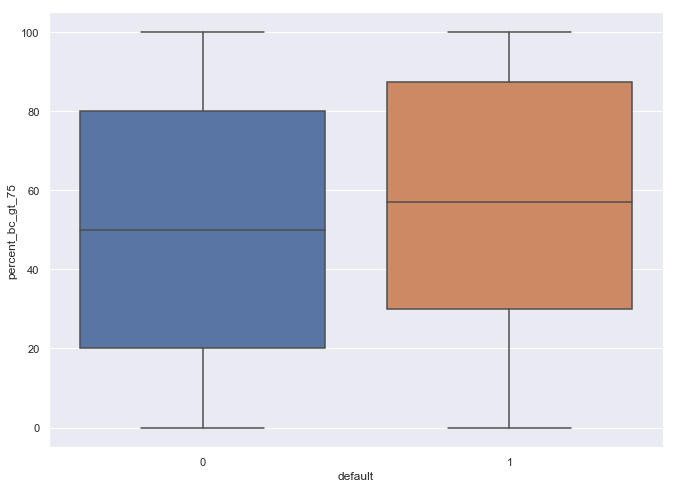

In [49]:
sns.set(rc={'figure.figsize':(11,8)})
sns.boxplot(x = 'default', y = 'percent_bc_gt_75', data=df_lend)

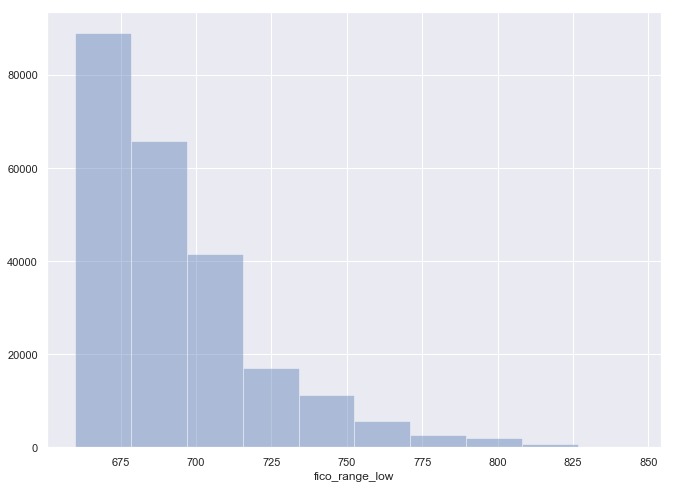

In [50]:
sns.set(rc={'figure.figsize':(11,8)})
sns.distplot(df_lend['fico_range_low'],bins=10,kde=False)

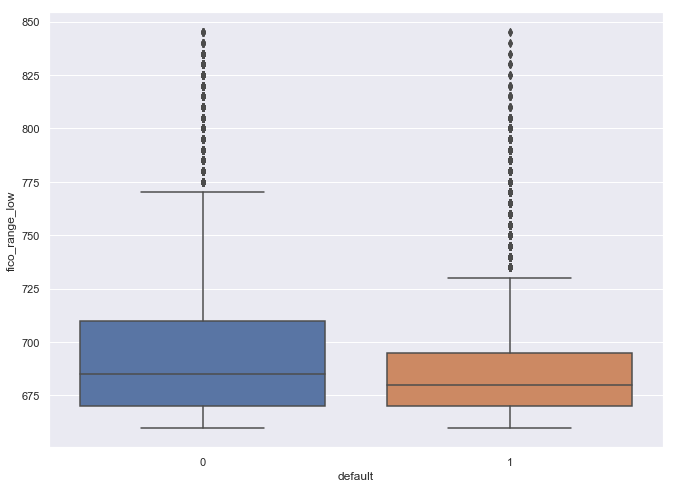

In [51]:
sns.set(rc={'figure.figsize':(11,8)})
sns.boxplot(x = 'default', y = 'fico_range_low', data=df_lend)

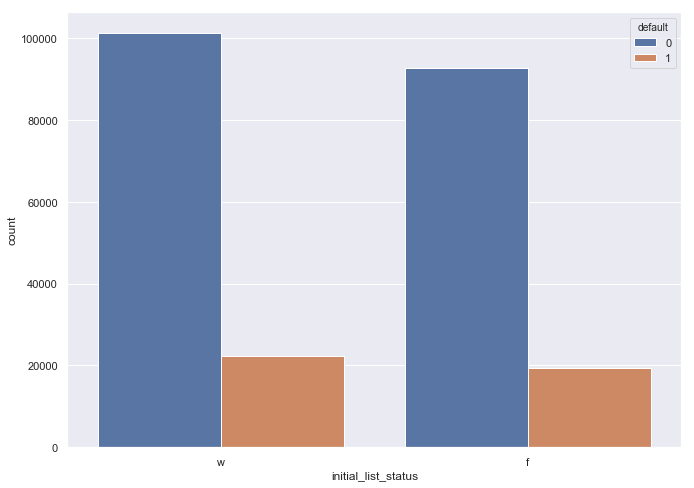

In [52]:
order = df_lend['initial_list_status'].value_counts().index.tolist()
sns.set(rc={'figure.figsize':(11,8)})
sns.countplot(x='initial_list_status', hue='default', order = order, data=df_lend)

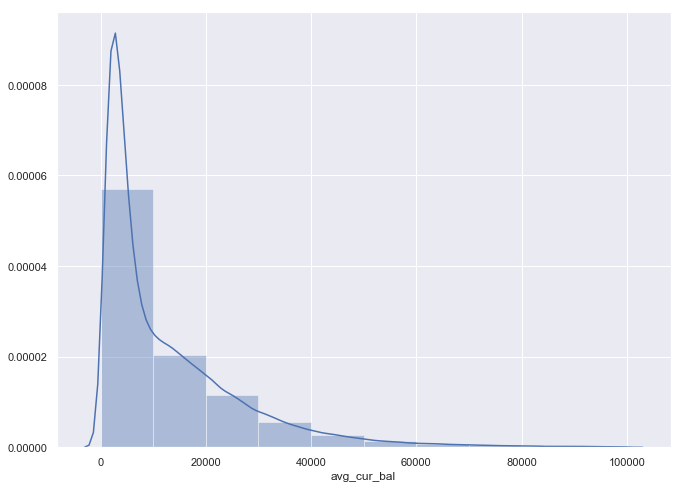

In [53]:
cur_bal_100k = df_lend[df_lend['avg_cur_bal'] < 100000]
sns.set(rc={'figure.figsize':(11,8)})
sns.distplot(cur_bal_100k['avg_cur_bal'],bins=10)

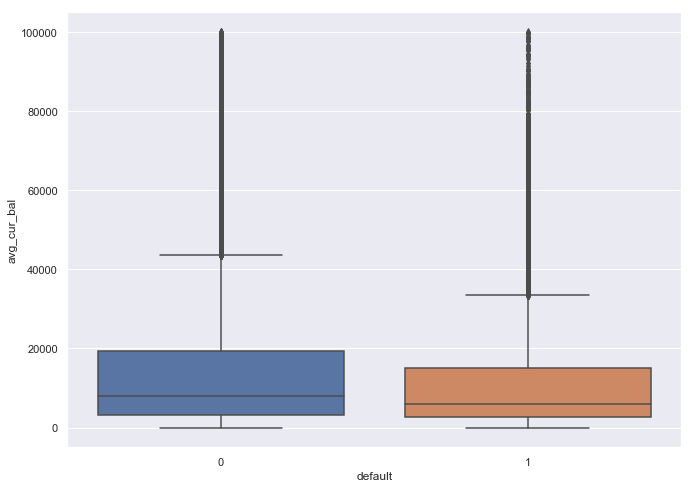

In [54]:
sns.set(rc={'figure.figsize':(11,8)})
sns.boxplot(x = 'default', y = 'avg_cur_bal', data=cur_bal_100k)

## FEATURE ENGINEERING

Convert term limit int which is either 36 or 60. Currently it is a categorical feature.

In [55]:
df_lend['term'] = [int(i[:3]) for i in df_lend['term']]

Convert 'issue_d' from their date formats into month format since each value has the same day value.

In [56]:
df_lend['issue_d'] = [date.month for date in [datetime.strptime(i[0:3],'%b') for i in df_lend['issue_d']]]

Calculate days from today using 'earliest_cr_line' dates.

In [57]:
df_lend['earliest_cr_line'] = [(datetime.utcnow() - datetime(int('19'+df_lend['earliest_cr_line'].iloc[i][4:6]),
                                int(datetime.strptime(df_lend['earliest_cr_line'].iloc[i][0:3],'%b').month),1)).days 
                                for i in range(len(df_lend))]

Remove outliers from 'annual_inc' feature.

In [58]:
upper_lim = df_lend['annual_inc'].quantile(.95)
lower_lim = df_lend['annual_inc'].quantile(.05)

df_lend = df_lend[(df_lend['annual_inc'] < upper_lim) & (df_lend['annual_inc'] > lower_lim)]

We can change verification status to either a 1 or 0, representing if they're verified or not.

In [59]:
df_lend['verification_status'] = np.where(df_lend['verification_status'] == 'Not Verified',0,1)

Another feature we can generate is census tract region from 'addr_state'

In [60]:
northeast = ['ME','NH','VT','NY','PA','NJ','CT','RI','MA']
midwest = ['MI','OH','IN','IL','WI','IA','MO','KS','NE','SD','ND']
south = ['TX','OK','AR','LA','MS','AL','GA','FL','SC','NC','TN','KY','VA','WV','MD','DE','DC']
west = ['WA','OR','CA','AK','HI','NV','ID','MT','WY','CO','NM']

regions = []
for state in df_lend['addr_state']:
    if state in northeast:
        regions.append('NE')
    elif state in midwest:
        regions.append('MW')
    elif state in south:
        regions.append('S')
    else:
        regions.append('W')

df_lend['region'] = regions

Text(0, 0.5, 'Percentage of job role Low Risk')

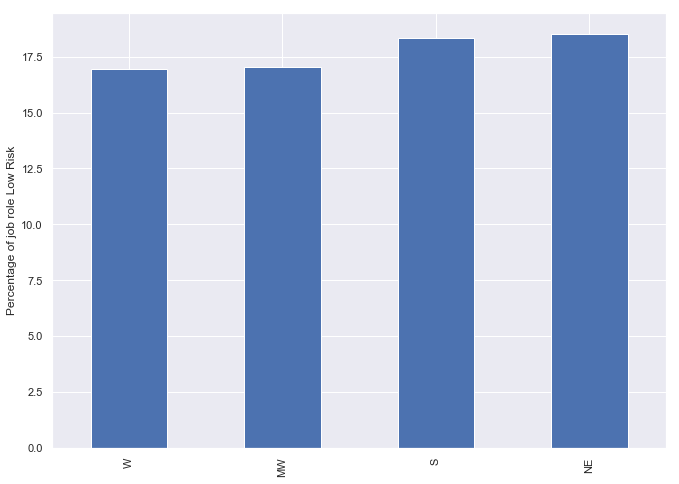

In [61]:
reg_counts = df_lend['region'].value_counts()
def_reg_counts = df_lend[df_lend['default']==1]['region'].value_counts()

divide = (def_reg_counts.div(reg_counts) * 100).sort_values()
ax = divide.plot.bar()
plt.ylabel('Percentage of job role Low Risk')

In [62]:
df_lend.drop(columns=['addr_state'],inplace=True)

A good feature to add would be decline in credit to capture individuals that are having trouble paying off their credit lines.

In [63]:
df_lend['fico_range_low_change'] = df_lend['fico_range_low'] - df_lend['last_fico_range_low']

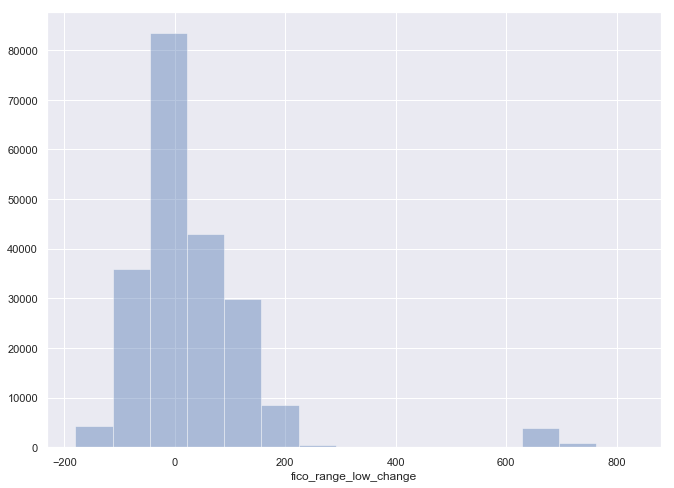

In [64]:
sns.set(rc={'figure.figsize':(11,8)})
sns.distplot(df_lend['fico_range_low_change'], bins=15, kde=False)

Bin the difference in fico scores.

In [65]:
df_lend['fico_range_low_change'].describe()

count    210245.000000
mean         31.292445
std         124.408756
min        -180.000000
25%         -35.000000
50%           5.000000
75%          70.000000
max         830.000000
Name: fico_range_low_change, dtype: float64

In [66]:
col = []
for value in df_lend['fico_range_low_change']:
    if value < -50:
        col.append('Large Decrease')
    elif value < 0:
        col.append('Small Decrease')
    elif value < 50:
        col.append('Small Increase')
    else:
        col.append('Large Increase')

In [67]:
df_lend['agg_crd_change'] = col

Something to consider, for columns that are in date format, we can look at the how long since the most recent date.

In [68]:
df_lend['last_pymnt_d'] = df_lend['last_pymnt_d'].map(months_since_dec19)

In [69]:
df_lend['last_pymnt_d'].head()

0    40
1    42
2    56
3     3
4    43
Name: last_pymnt_d, dtype: int64

Repeat the same for 'last_credit_pull_d'.

In [70]:
df_lend['last_credit_pull_d'] = df_lend['last_credit_pull_d'].map(months_since_dec19)

Drop zipcode since we aggregated onto region level census data.

In [71]:
df_lend.drop(columns='zip_code',inplace=True)

In [72]:
df_lend.head()

,term,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,earliest_cr_line,fico_range_low,inq_last_6mths,revol_util,initial_list_status,total_rec_prncp,total_rec_late_fee,recoveries,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_low,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,default,region,fico_range_low_change,agg_crd_change
0,36,8 years,MORTGAGE,58000.0,0,12,credit_card,14.92,11232,710,2,31.6,w,5217.75,0.0,521.27,40,321.08,34,560,7,9536.0,7599.0,41.5,290,1,1,1,5.0,9,4,14.3,179407,13000,1,W,150,Large Increase
1,60,10+ years,RENT,78000.0,1,12,debt_consolidation,12.03,9437,750,0,29.0,w,15000.00,0.0,0.00,42,12017.81,1,680,5,29828.0,9525.0,4.7,244,1,1,0,47.0,4,4,0.0,196500,10000,0,S,70,Large Increase
2,36,10+ years,RENT,69000.0,1,12,debt_consolidation,25.81,10075,680,0,59.4,f,9600.00,0.0,0.00,56,9338.58,5,710,8,3214.0,6494.0,69.2,265,23,3,0,24.0,7,3,60.0,52490,21100,0,NE,-30,Small Decrease
3,60,10+ years,MORTGAGE,125000.0,1,12,car,8.31,43709,665,0,100.9,w,12800.00,0.0,0.00,3,1576.08,3,660,2,32727.0,0.0,103.2,170,21,16,5,21.0,5,0,100.0,368700,4400,0,W,5,Small Increase
4,60,6 years,RENT,63800.0,1,12,credit_card,18.49,42675,685,0,76.2,w,21425.00,0.0,0.00,43,17813.19,20,525,4,4232.0,324.0,97.8,136,7,7,0,7.0,4,2,100.0,57073,15000,0,MW,160,Large Increase


Next, we need to one-hot-encode the categorical features in the dataset. This can increase the memory usage by a factor so be aware of how many unique values each feature has.

In [73]:
X = dummy_var(df_lend, dependent = 'default', benchmark = 0.05)

emp_length did not have a correlation strong enough.
home_ownership was converted to dummy variables.
purpose did not have a correlation strong enough.
initial_list_status did not have a correlation strong enough.
region did not have a correlation strong enough.
agg_crd_change was converted to dummy variables.


In [74]:
X.head()

,term,annual_inc,verification_status,issue_d,dti,earliest_cr_line,fico_range_low,inq_last_6mths,revol_util,total_rec_prncp,total_rec_late_fee,recoveries,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_low,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,default,fico_range_low_change,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,agg_crd_change_Large Decrease,agg_crd_change_Large Increase,agg_crd_change_Small Decrease,agg_crd_change_Small Increase
0,36,58000.0,0,12,14.92,11232,710,2,31.6,5217.75,0.0,521.27,40,321.08,34,560,7,9536.0,7599.0,41.5,290,1,1,1,5.0,9,4,14.3,179407,13000,1,150,0,1,0,0,0,1,0,0
1,60,78000.0,1,12,12.03,9437,750,0,29.0,15000.00,0.0,0.00,42,12017.81,1,680,5,29828.0,9525.0,4.7,244,1,1,0,47.0,4,4,0.0,196500,10000,0,70,0,0,0,1,0,1,0,0
2,36,69000.0,1,12,25.81,10075,680,0,59.4,9600.00,0.0,0.00,56,9338.58,5,710,8,3214.0,6494.0,69.2,265,23,3,0,24.0,7,3,60.0,52490,21100,0,-30,0,0,0,1,0,0,1,0
3,60,125000.0,1,12,8.31,43709,665,0,100.9,12800.00,0.0,0.00,3,1576.08,3,660,2,32727.0,0.0,103.2,170,21,16,5,21.0,5,0,100.0,368700,4400,0,5,0,1,0,0,0,0,0,1
4,60,63800.0,1,12,18.49,42675,685,0,76.2,21425.00,0.0,0.00,43,17813.19,20,525,4,4232.0,324.0,97.8,136,7,7,0,7.0,4,2,100.0,57073,15000,0,160,0,0,0,1,0,1,0,0


Save to csv for easier loading later.

In [75]:
X.to_csv('lending_tree_feature_eng.csv')

In [76]:
X.head()

,term,annual_inc,verification_status,issue_d,dti,earliest_cr_line,fico_range_low,inq_last_6mths,revol_util,total_rec_prncp,total_rec_late_fee,recoveries,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_low,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,default,fico_range_low_change,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,agg_crd_change_Large Decrease,agg_crd_change_Large Increase,agg_crd_change_Small Decrease,agg_crd_change_Small Increase
0,36,58000.0,0,12,14.92,11232,710,2,31.6,5217.75,0.0,521.27,40,321.08,34,560,7,9536.0,7599.0,41.5,290,1,1,1,5.0,9,4,14.3,179407,13000,1,150,0,1,0,0,0,1,0,0
1,60,78000.0,1,12,12.03,9437,750,0,29.0,15000.00,0.0,0.00,42,12017.81,1,680,5,29828.0,9525.0,4.7,244,1,1,0,47.0,4,4,0.0,196500,10000,0,70,0,0,0,1,0,1,0,0
2,36,69000.0,1,12,25.81,10075,680,0,59.4,9600.00,0.0,0.00,56,9338.58,5,710,8,3214.0,6494.0,69.2,265,23,3,0,24.0,7,3,60.0,52490,21100,0,-30,0,0,0,1,0,0,1,0
3,60,125000.0,1,12,8.31,43709,665,0,100.9,12800.00,0.0,0.00,3,1576.08,3,660,2,32727.0,0.0,103.2,170,21,16,5,21.0,5,0,100.0,368700,4400,0,5,0,1,0,0,0,0,0,1
4,60,63800.0,1,12,18.49,42675,685,0,76.2,21425.00,0.0,0.00,43,17813.19,20,525,4,4232.0,324.0,97.8,136,7,7,0,7.0,4,2,100.0,57073,15000,0,160,0,0,0,1,0,1,0,0


## PREDICTIVE MODELING

In [77]:
X = pd.read_csv('lending_tree_feature_eng.csv',index_col=0)

In [78]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210245 entries, 0 to 235606
Data columns (total 40 columns):
term                             210245 non-null int64
annual_inc                       210245 non-null float64
verification_status              210245 non-null int64
issue_d                          210245 non-null int64
dti                              210245 non-null float64
earliest_cr_line                 210245 non-null int64
fico_range_low                   210245 non-null int64
inq_last_6mths                   210245 non-null int64
revol_util                       210245 non-null float64
total_rec_prncp                  210245 non-null float64
total_rec_late_fee               210245 non-null float64
recoveries                       210245 non-null float64
last_pymnt_d                     210245 non-null int64
last_pymnt_amnt                  210245 non-null float64
last_credit_pull_d               210245 non-null int64
last_fico_range_low              210245 non-null i

In [79]:
X.head()

,term,annual_inc,verification_status,issue_d,dti,earliest_cr_line,fico_range_low,inq_last_6mths,revol_util,total_rec_prncp,total_rec_late_fee,recoveries,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_low,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,default,fico_range_low_change,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,agg_crd_change_Large Decrease,agg_crd_change_Large Increase,agg_crd_change_Small Decrease,agg_crd_change_Small Increase
0,36,58000.0,0,12,14.92,11232,710,2,31.6,5217.75,0.0,521.27,40,321.08,34,560,7,9536.0,7599.0,41.5,290,1,1,1,5.0,9,4,14.3,179407,13000,1,150,0,1,0,0,0,1,0,0
1,60,78000.0,1,12,12.03,9437,750,0,29.0,15000.00,0.0,0.00,42,12017.81,1,680,5,29828.0,9525.0,4.7,244,1,1,0,47.0,4,4,0.0,196500,10000,0,70,0,0,0,1,0,1,0,0
2,36,69000.0,1,12,25.81,10075,680,0,59.4,9600.00,0.0,0.00,56,9338.58,5,710,8,3214.0,6494.0,69.2,265,23,3,0,24.0,7,3,60.0,52490,21100,0,-30,0,0,0,1,0,0,1,0
3,60,125000.0,1,12,8.31,43709,665,0,100.9,12800.00,0.0,0.00,3,1576.08,3,660,2,32727.0,0.0,103.2,170,21,16,5,21.0,5,0,100.0,368700,4400,0,5,0,1,0,0,0,0,0,1
4,60,63800.0,1,12,18.49,42675,685,0,76.2,21425.00,0.0,0.00,43,17813.19,20,525,4,4232.0,324.0,97.8,136,7,7,0,7.0,4,2,100.0,57073,15000,0,160,0,0,0,1,0,1,0,0


Split into dependent and independent sets

In [80]:
y = X['default'].copy()
X.drop('default', axis = 1, inplace = True)

Split dataset into training and test set with KFolds split.

In [81]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 42049  42050  42051 ... 210242 210243 210244] TEST: [    0     1     2 ... 42046 42047 42048]
TRAIN: [     0      1      2 ... 210242 210243 210244] TEST: [42049 42050 42051 ... 84095 84096 84097]
TRAIN: [     0      1      2 ... 210242 210243 210244] TEST: [ 84098  84099  84100 ... 126144 126145 126146]
TRAIN: [     0      1      2 ... 210242 210243 210244] TEST: [126147 126148 126149 ... 168193 168194 168195]
TRAIN: [     0      1      2 ... 168193 168194 168195] TEST: [168196 168197 168198 ... 210242 210243 210244]


In [82]:
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [83]:
X_train.head()

,term,annual_inc,verification_status,issue_d,dti,earliest_cr_line,fico_range_low,inq_last_6mths,revol_util,total_rec_prncp,total_rec_late_fee,recoveries,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_low,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,fico_range_low_change,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,agg_crd_change_Large Decrease,agg_crd_change_Large Increase,agg_crd_change_Small Decrease,agg_crd_change_Small Increase
0,36,58000.0,0,12,14.92,11232,710,2,31.6,5217.75,0.0,521.27,40,321.08,34,560,7,9536.0,7599.0,41.5,290,1,1,1,5.0,9,4,14.3,179407,13000,150,0,1,0,0,0,1,0,0
1,60,78000.0,1,12,12.03,9437,750,0,29.0,15000.00,0.0,0.00,42,12017.81,1,680,5,29828.0,9525.0,4.7,244,1,1,0,47.0,4,4,0.0,196500,10000,70,0,0,0,1,0,1,0,0
2,36,69000.0,1,12,25.81,10075,680,0,59.4,9600.00,0.0,0.00,56,9338.58,5,710,8,3214.0,6494.0,69.2,265,23,3,0,24.0,7,3,60.0,52490,21100,-30,0,0,0,1,0,0,1,0
3,60,125000.0,1,12,8.31,43709,665,0,100.9,12800.00,0.0,0.00,3,1576.08,3,660,2,32727.0,0.0,103.2,170,21,16,5,21.0,5,0,100.0,368700,4400,5,0,1,0,0,0,0,0,1
4,60,63800.0,1,12,18.49,42675,685,0,76.2,21425.00,0.0,0.00,43,17813.19,20,525,4,4232.0,324.0,97.8,136,7,7,0,7.0,4,2,100.0,57073,15000,160,0,0,0,1,0,1,0,0


Logisitc regression model and grab coefficients, from the coefficients we can determine which are being weighted too much. The coefficients that weigh more heavily will be dropped to prevent overfitting.

In [84]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

classifiers = [RidgeClassifier(),
               LogisticRegressionCV(Cs=[1e-4], cv=3, max_iter=50, n_jobs = -1),
               RandomForestClassifier(max_depth=10, n_estimators=100, max_features='sqrt'),
               BernoulliNB()]

names = ['Ridge','Logistic','Random Forest','BernoulliNB']
f1_test = []
f1_train = []
auroc_test = []
auroc_train = []
accuracy_test = []
accuracy_train = []

for clf,name in zip(classifiers,names):
    clf.fit(X_train,y_train)
    pred_ytest = clf.predict(X_test)
    pred_ytrain = clf.predict(X_train)
    f1_ytest = f1_score(y_test,pred_ytest)
    f1_test.append(f1_ytest)
    f1_ytrain = f1_score(y_train,pred_ytrain)
    f1_train.append(f1_ytrain)
    auroc_ytest = roc_auc_score(y_test,pred_ytest)
    auroc_test.append(auroc_ytest)
    auroc_ytrain = roc_auc_score(y_train,pred_ytrain)
    auroc_train.append(auroc_ytrain)
    accuracy_yest = accuracy_score(y_test,pred_ytest)
    accuracy_test.append(accuracy_yest)
    accuracy_ytrain = accuracy_score(y_train,pred_ytrain)
    accuracy_train.append(accuracy_ytrain)

C:\Users\Thom\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<Figure size 792x576 with 0 Axes>

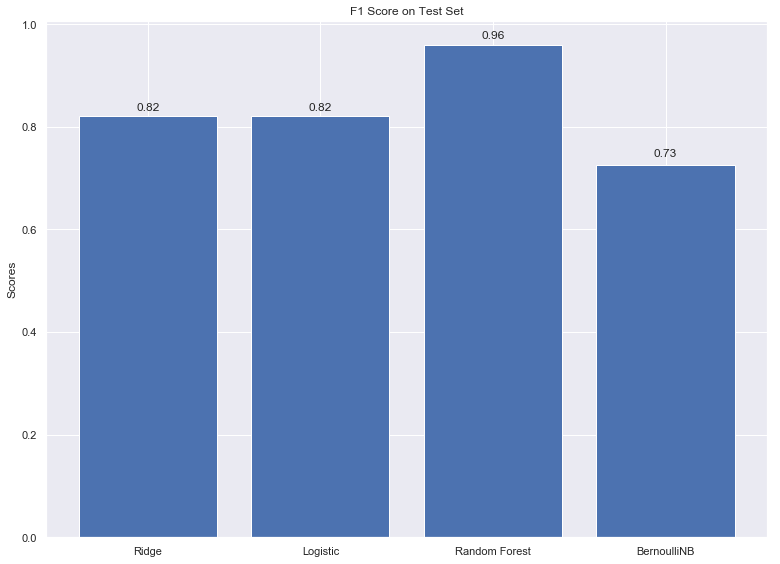

In [85]:
plt.figure(figsize=(11,8))
fig, ax = plt.subplots()
rects = ax.bar(names, f1_test)
ax.set_ylabel('Scores')
ax.set_title('F1 Score on Test Set')
for rect in rects:
        height = np.round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
fig.tight_layout()
plt.show()

<Figure size 792x576 with 0 Axes>

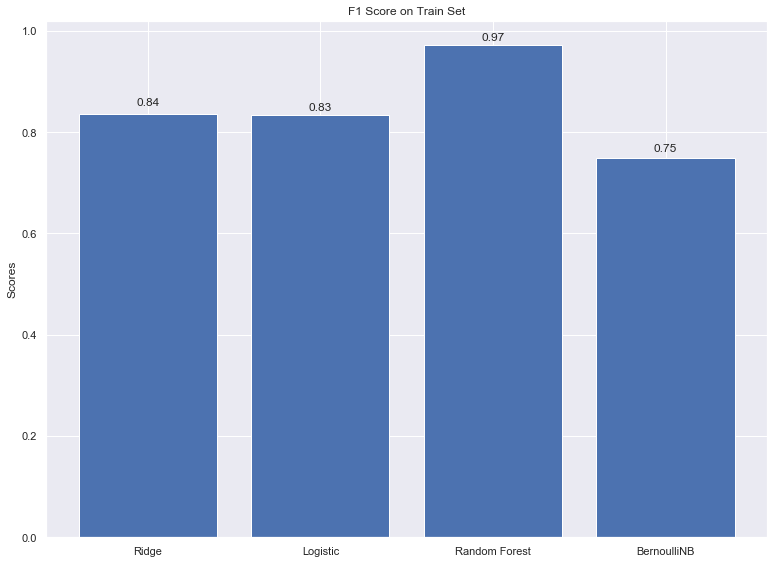

In [86]:
plt.figure(figsize=(11,8))
fig, ax = plt.subplots()
rects = ax.bar(names, f1_train)
ax.set_ylabel('Scores')
ax.set_title('F1 Score on Train Set')
for rect in rects:
        height = np.round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 4 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
fig.tight_layout()
plt.show()

<Figure size 792x576 with 0 Axes>

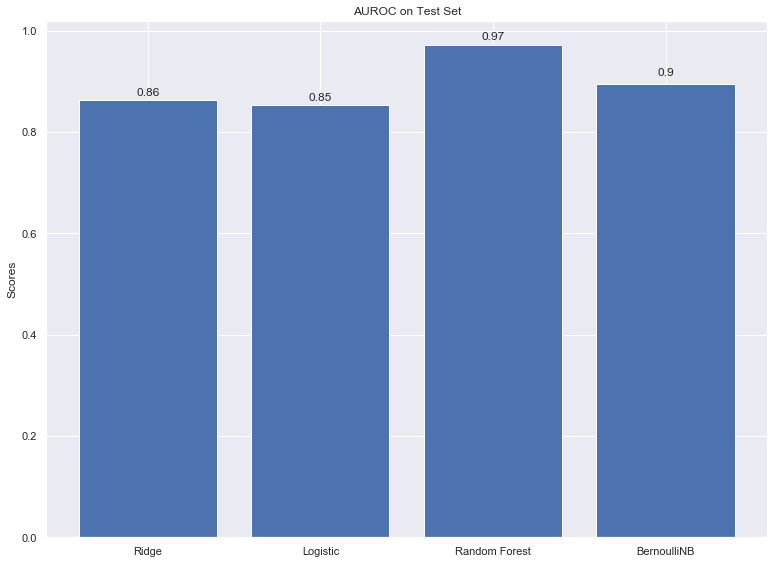

In [87]:
plt.figure(figsize=(11,8))
fig, ax = plt.subplots()
rects = ax.bar(names, auroc_test)
ax.set_ylabel('Scores')
ax.set_title('AUROC on Test Set')
for rect in rects:
        height = np.round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
fig.tight_layout()
plt.show()

<Figure size 792x576 with 0 Axes>

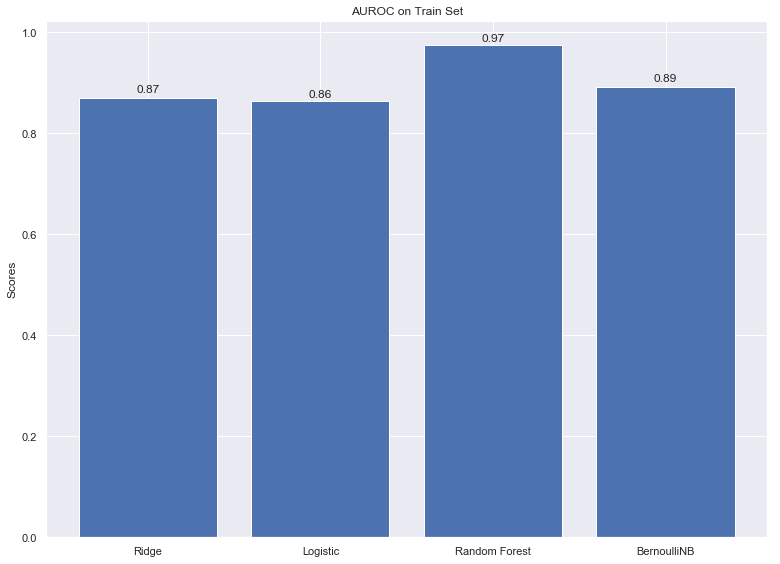

In [88]:
plt.figure(figsize=(11,8))
fig, ax = plt.subplots()
rects = ax.bar(names, auroc_train)
ax.set_ylabel('Scores')
ax.set_title('AUROC on Train Set')
for rect in rects:
        height = np.round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
fig.tight_layout()
plt.show()

<Figure size 792x576 with 0 Axes>

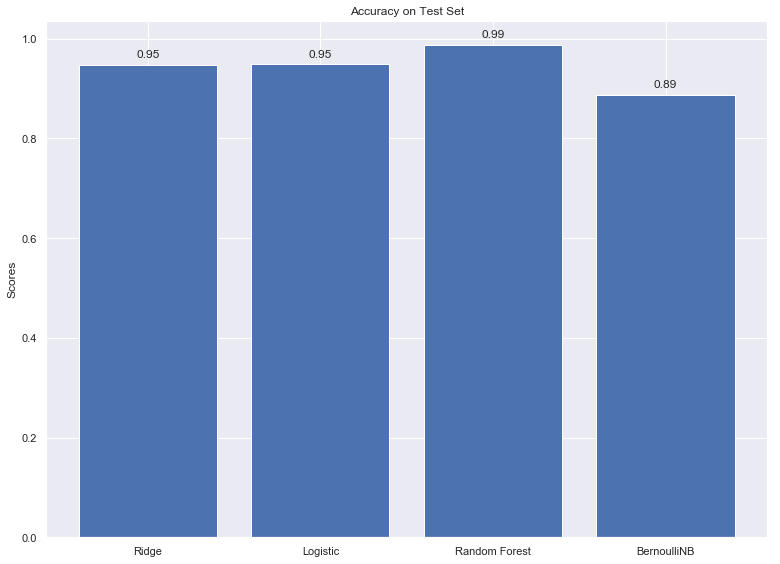

In [89]:
plt.figure(figsize=(11,8))
fig, ax = plt.subplots()
rects = ax.bar(names, accuracy_test)
ax.set_ylabel('Scores')
ax.set_title('Accuracy on Test Set')
for rect in rects:
        height = np.round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
fig.tight_layout()
plt.show()

<Figure size 792x576 with 0 Axes>

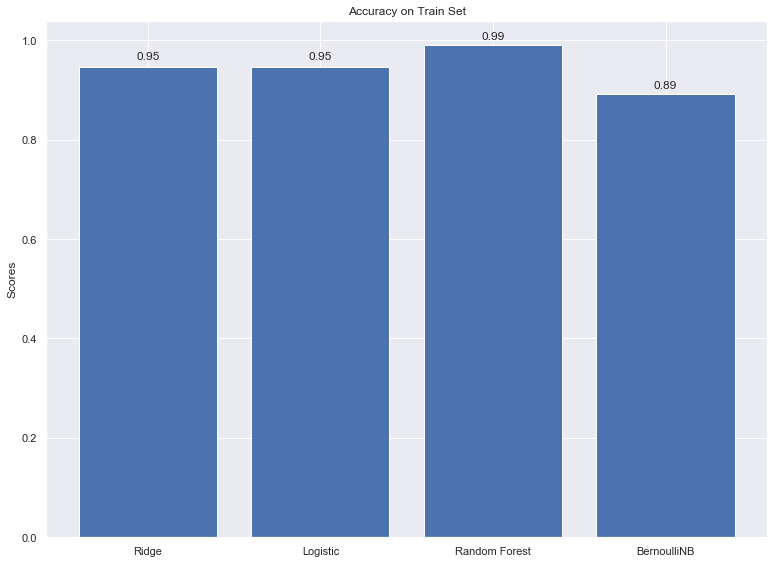

In [90]:
plt.figure(figsize=(11,8))
fig, ax = plt.subplots()
rects = ax.bar(names, accuracy_train)
ax.set_ylabel('Scores')
ax.set_title('Accuracy on Train Set')
for rect in rects:
        height = np.round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
fig.tight_layout()
plt.show()

I decide on a logistic classification model based on each models performance indicators. The random forest avoids overfitting judging by the f-score, and has high accuracy.

In [91]:
clf = LogisticRegressionCV(Cs=[1e-4], cv=5, max_iter=200, n_jobs = -1).fit(X_train,y_train)

# fit and predict
clf_ytest = clf.predict(X_test)
clf_ytrain = clf.predict(X_train)

print('f1_score on test set: ',(f1_score(y_test, clf_ytest)))
print('f1_score on train set: ',(f1_score(y_train, clf_ytrain)))
print('accuracy on test set: ',(accuracy_score(y_test, clf_ytest)))
print('accuracy on train set: ',(accuracy_score(y_train, clf_ytrain)))

C:\Users\Thom\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


f1_score on test set:  0.8659284633155422
f1_score on train set:  0.8766229108385338
accuracy on test set:  0.9599752669504625
accuracy on train set:  0.9590953411496111


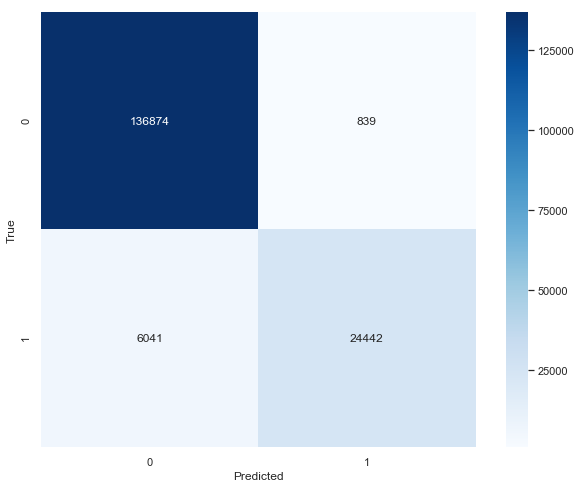

In [92]:
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(y_train,clf_ytrain)
ax = sns.heatmap(cm_test, cmap='Blues', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

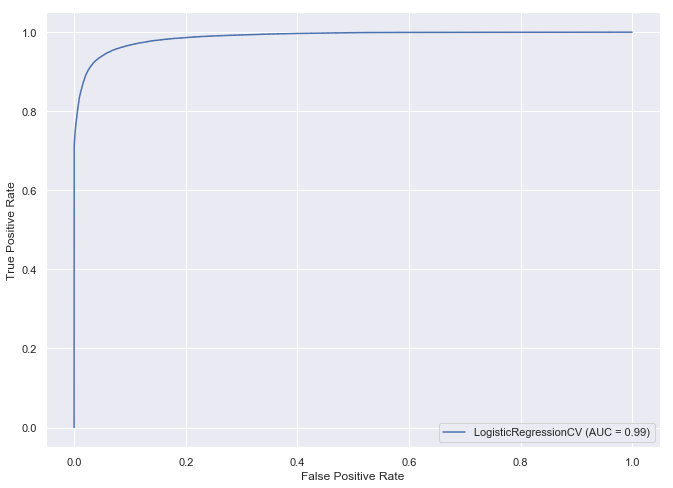

In [93]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf,X_train,y_train)

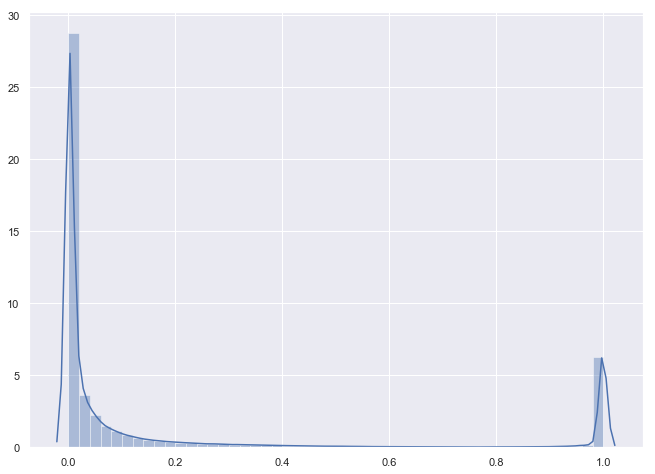

In [94]:
clf_y = clf.predict_proba(X)

# probability a row will default
clf_y[:,1]

sns.distplot(clf_y[:,1])